# Clustering Results
* https://realpython.com/python3-object-oriented-programming/
* https://github.com/jonatanr2000/indeng242


## Import Packages

In [41]:
import pandas as pd
import numpy as np
import json
import glob
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import time
import seaborn as sns
# 
import utils
import sqlite3
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score

## Data Importing/Processing

In [42]:
connection = utils.DataInterface(json_folder_path="data_playlist/")

In [43]:
query = '''
SELECT * 
FROM song
LIMIT 5
'''

songs = pd.read_sql(query, connection.con)
display(songs)
songs.columns

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [44]:
query = '''
SELECT * 
FROM playlist
LIMIT 5
'''

pd.read_sql(query, connection.con)

,pid,name,num_tracks
0,0,Throwbacks,52
1,1,Awesome Playlist,39
2,2,korean,64
3,3,mat,126
4,4,90s,17


In [45]:
query = '''
SELECT * 
FROM playlistsongs
LIMIT 5
'''

pd.read_sql(query, connection.con)

,pid,uri,pos
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,1
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,2
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT,3
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H,4


In [46]:
list_dfs = []
for i in range(0,15000):
    try:
        temp_df = connection.get_playlist_as_dataframe(pid = i)[
        ['danceability', 
        'energy', 
        'key', 
        'loudness', 
        'mode', 
        'speechiness',
        'acousticness', 
        'instrumentalness', 
        'liveness', 
        'valence', 
        'tempo', 
        'duration_ms',
        'time_signature']].apply(np.mean)
        list_dfs.append(temp_df)
    except KeyError:
        print(i)
        pass
df_playlist = pd.concat(list_dfs, axis=1).T
df_playlist.reset_index(inplace=True)
df_playlist = df_playlist.rename(columns = {'index':'pid'})

## Clustering

### K-Means

In [47]:
X = df_playlist.copy()
X = X.drop(['pid'], axis = 1)
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000
1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231
2,0.671063,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000
3,0.514429,0.620902,5.103175,-9.618754,0.714286,0.067000,0.273514,0.203156,0.188278,0.451258,125.547627,229575.055556,3.952381
4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176


In [48]:
def create_silhouette_plot(X, cluster_labels):
    #------------------------------------------------------
    #INPUT:
    #-----------------------------------------------------
    #X=dataframe of objects you clusterted
    #cluster_labels=cluster labels of each of the objects in the dataset X that you just clustered 

    #Gets the unique labels in the cluster_labels
    clabels=np.unique(cluster_labels)
    #Gets the number of unique labels
    k=len(clabels)
    
    #-------------------------------------------------------
    #SETTING UP THE PLOT SPACE
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    #FINDS THE SILHOUETTE SCORE FOR EACH OBJECT
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10

    
    for i in clabels:
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    plt.show()

2
3
4
5
6
7
8
9
10


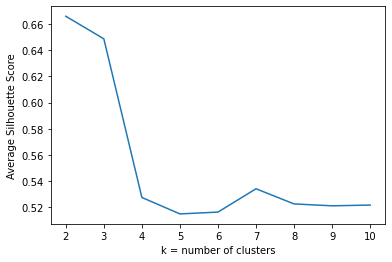

In [49]:
cluster_num_list = range(2,11) 
silhouette_avg_list = [] 
for k in cluster_num_list:
    print(k)
    kmeans = KMeans(n_clusters = k, random_state = 100).fit(X) 
    cluster_labels = kmeans.labels_ 
    silhouette_avg = silhouette_score(X,cluster_labels) 
    silhouette_avg_list.append(silhouette_avg)
plt.plot(cluster_num_list, silhouette_avg_list) 
plt.xlabel('k = number of clusters') 
plt.ylabel('Average Silhouette Score') 
plt.show()

In [50]:
kmeans_n = KMeans(n_clusters = 7, random_state = 100).fit(X)

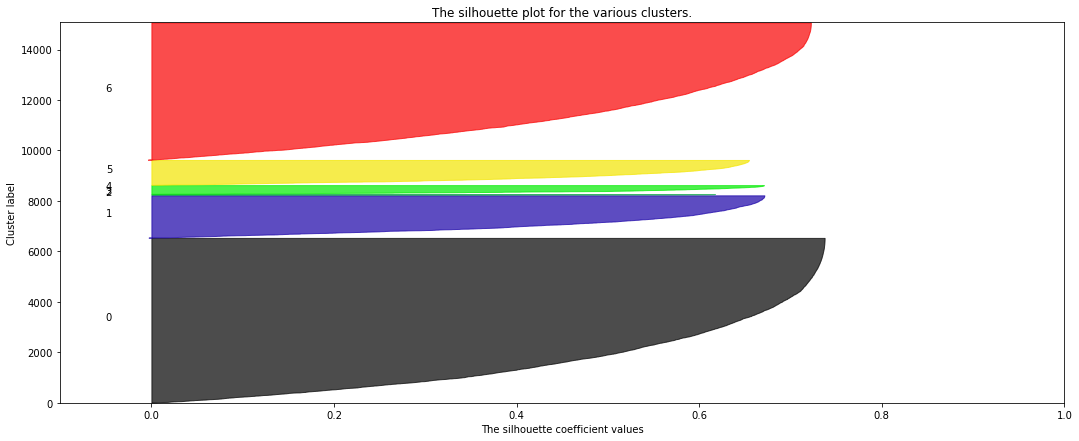

In [51]:
create_silhouette_plot(X, kmeans_n.labels_)

In [52]:
X['predicted_cluster'] = kmeans_n.labels_

/Users/lightning/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lightning/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


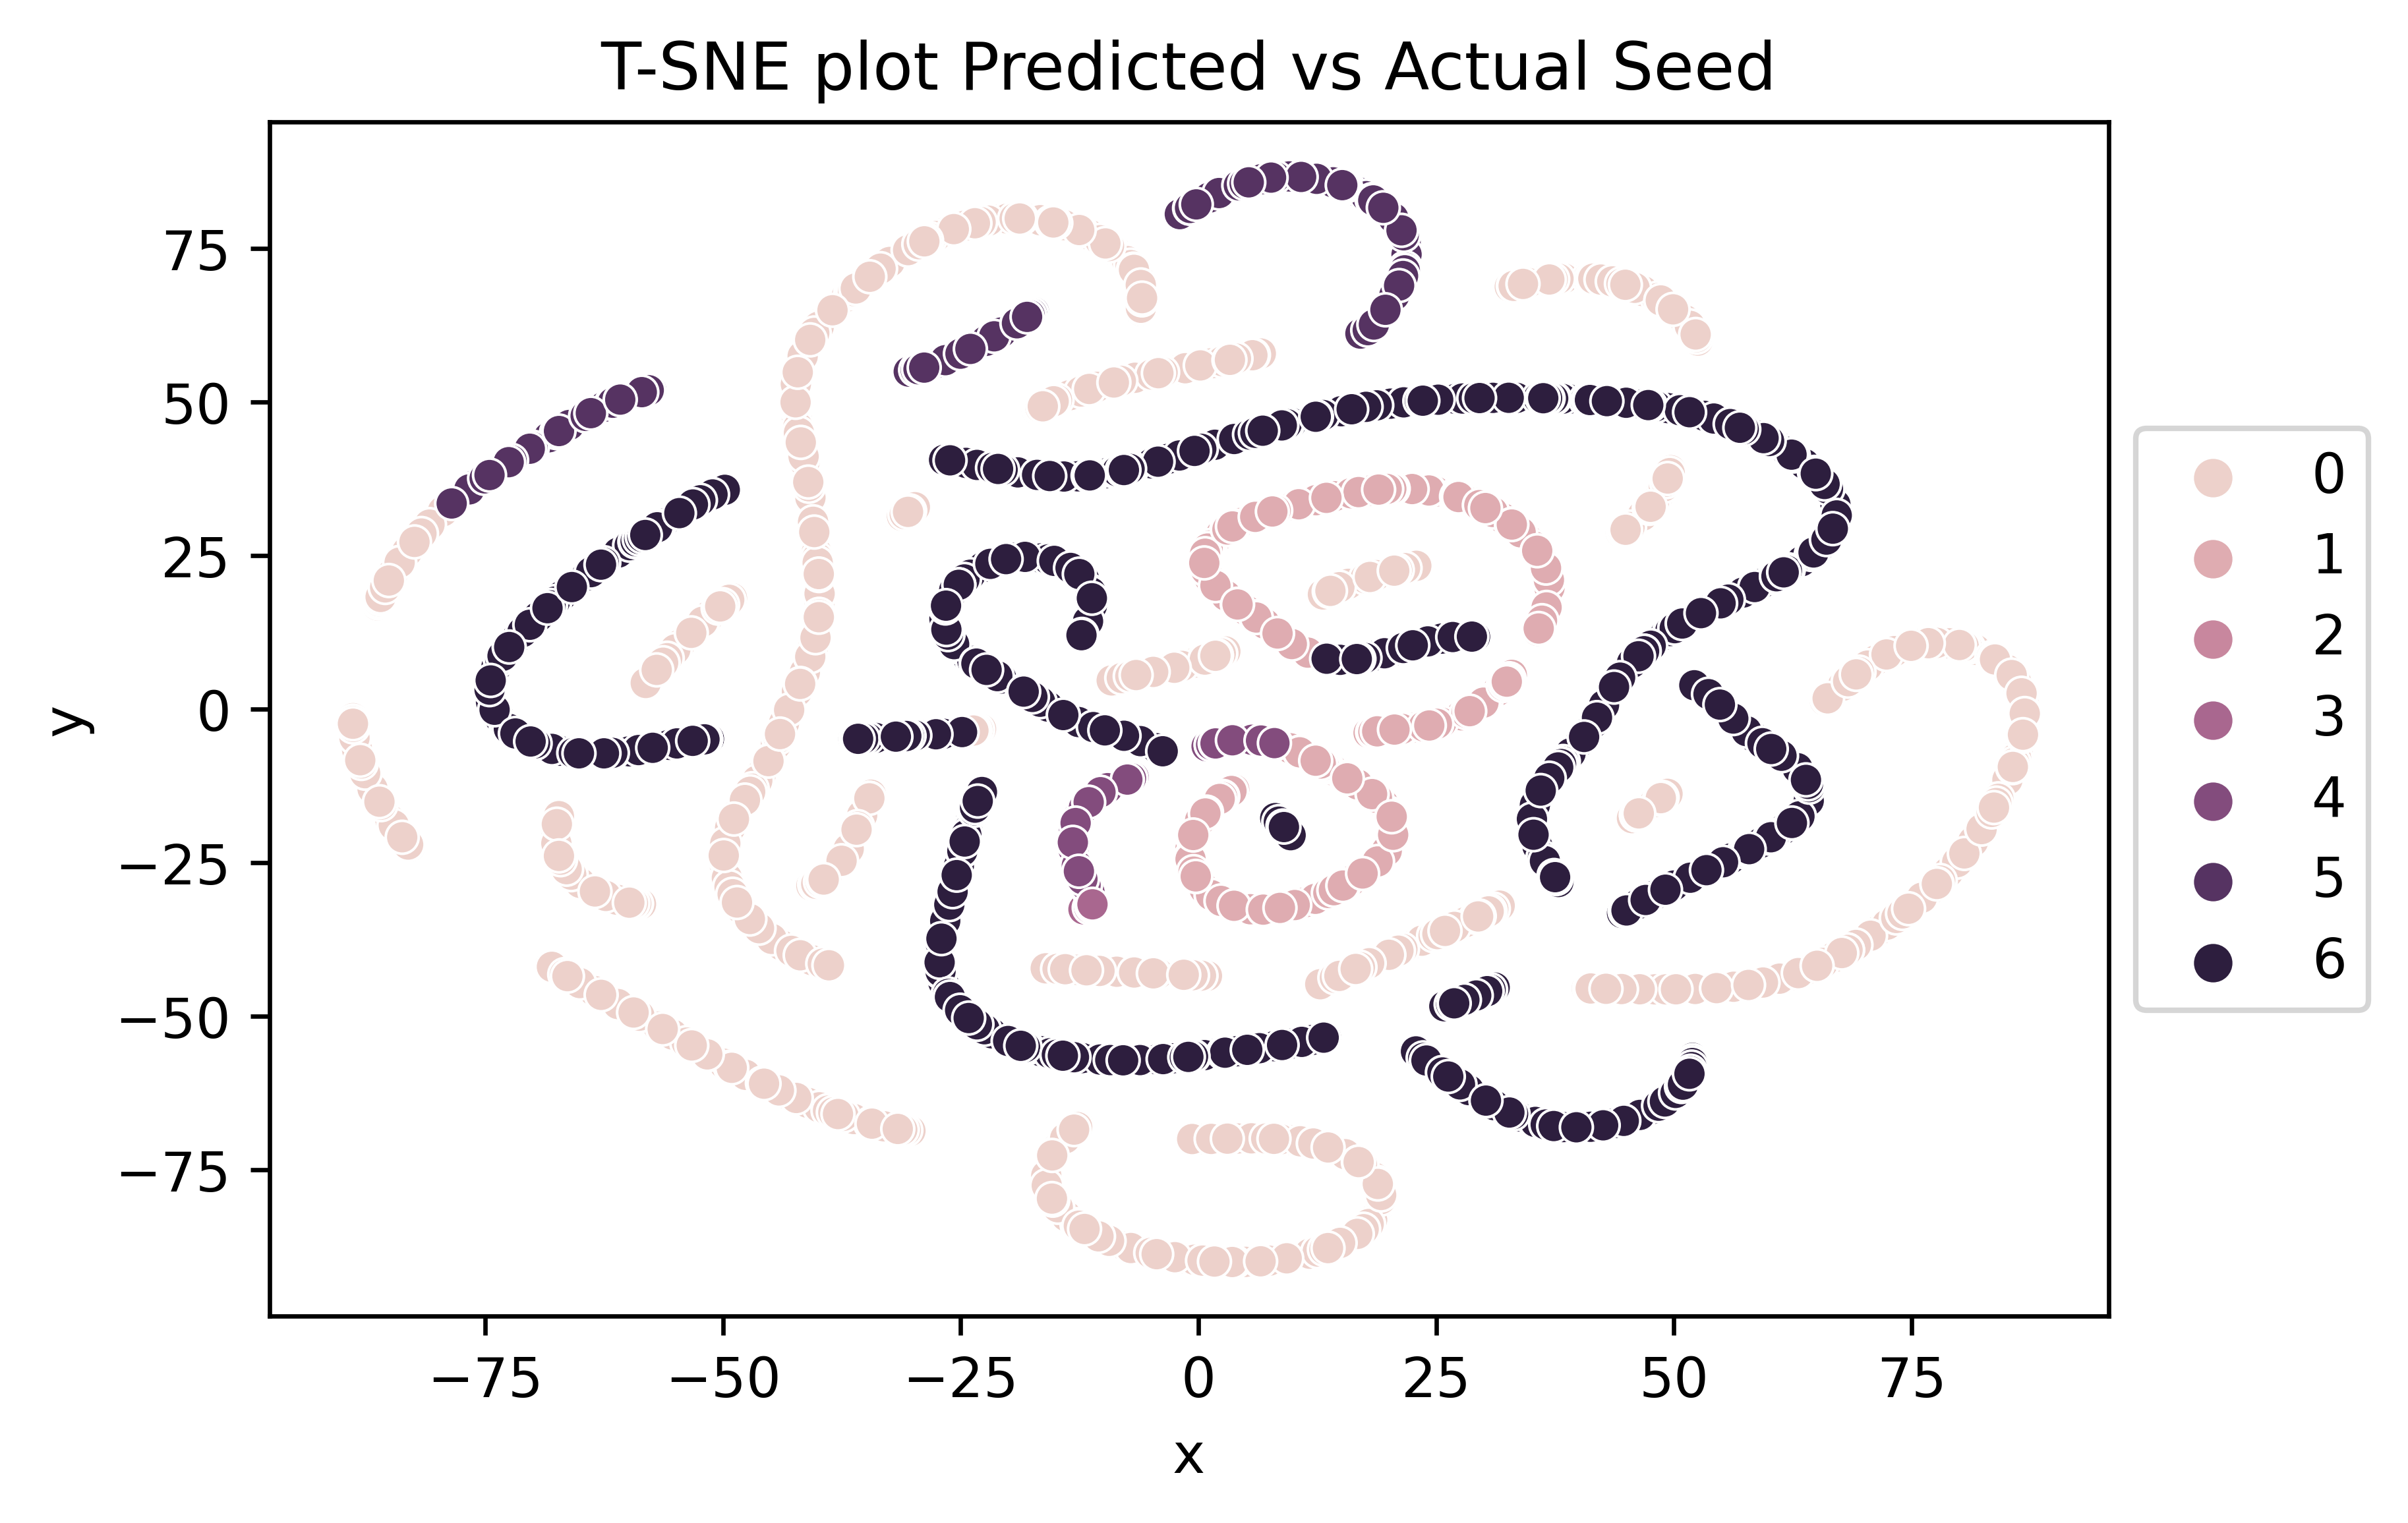

In [53]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components = 2, perplexity = 50, random_state = 1000)
data_tsne = tsne.fit_transform(X)

#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=X.index)
dff = pd.concat([X, df_tsne], axis=1)

plt.figure(dpi=600) 
# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue='predicted_cluster' , data=dff)
plt.title('T-SNE plot Predicted vs Actual Seed')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Spectral Clustering

In [39]:
sc = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', n_neighbors=35, random_state=1000)
X['predicted_cluster']=sc.fit_predict(X)
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,predicted_cluster
0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000,0
1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231,6
2,0.671063,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000,0
3,0.514429,0.620902,5.103175,-9.618754,0.714286,0.067000,0.273514,0.203156,0.188278,0.451258,125.547627,229575.055556,3.952381,7
4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176,2


/Users/lightning/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lightning/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


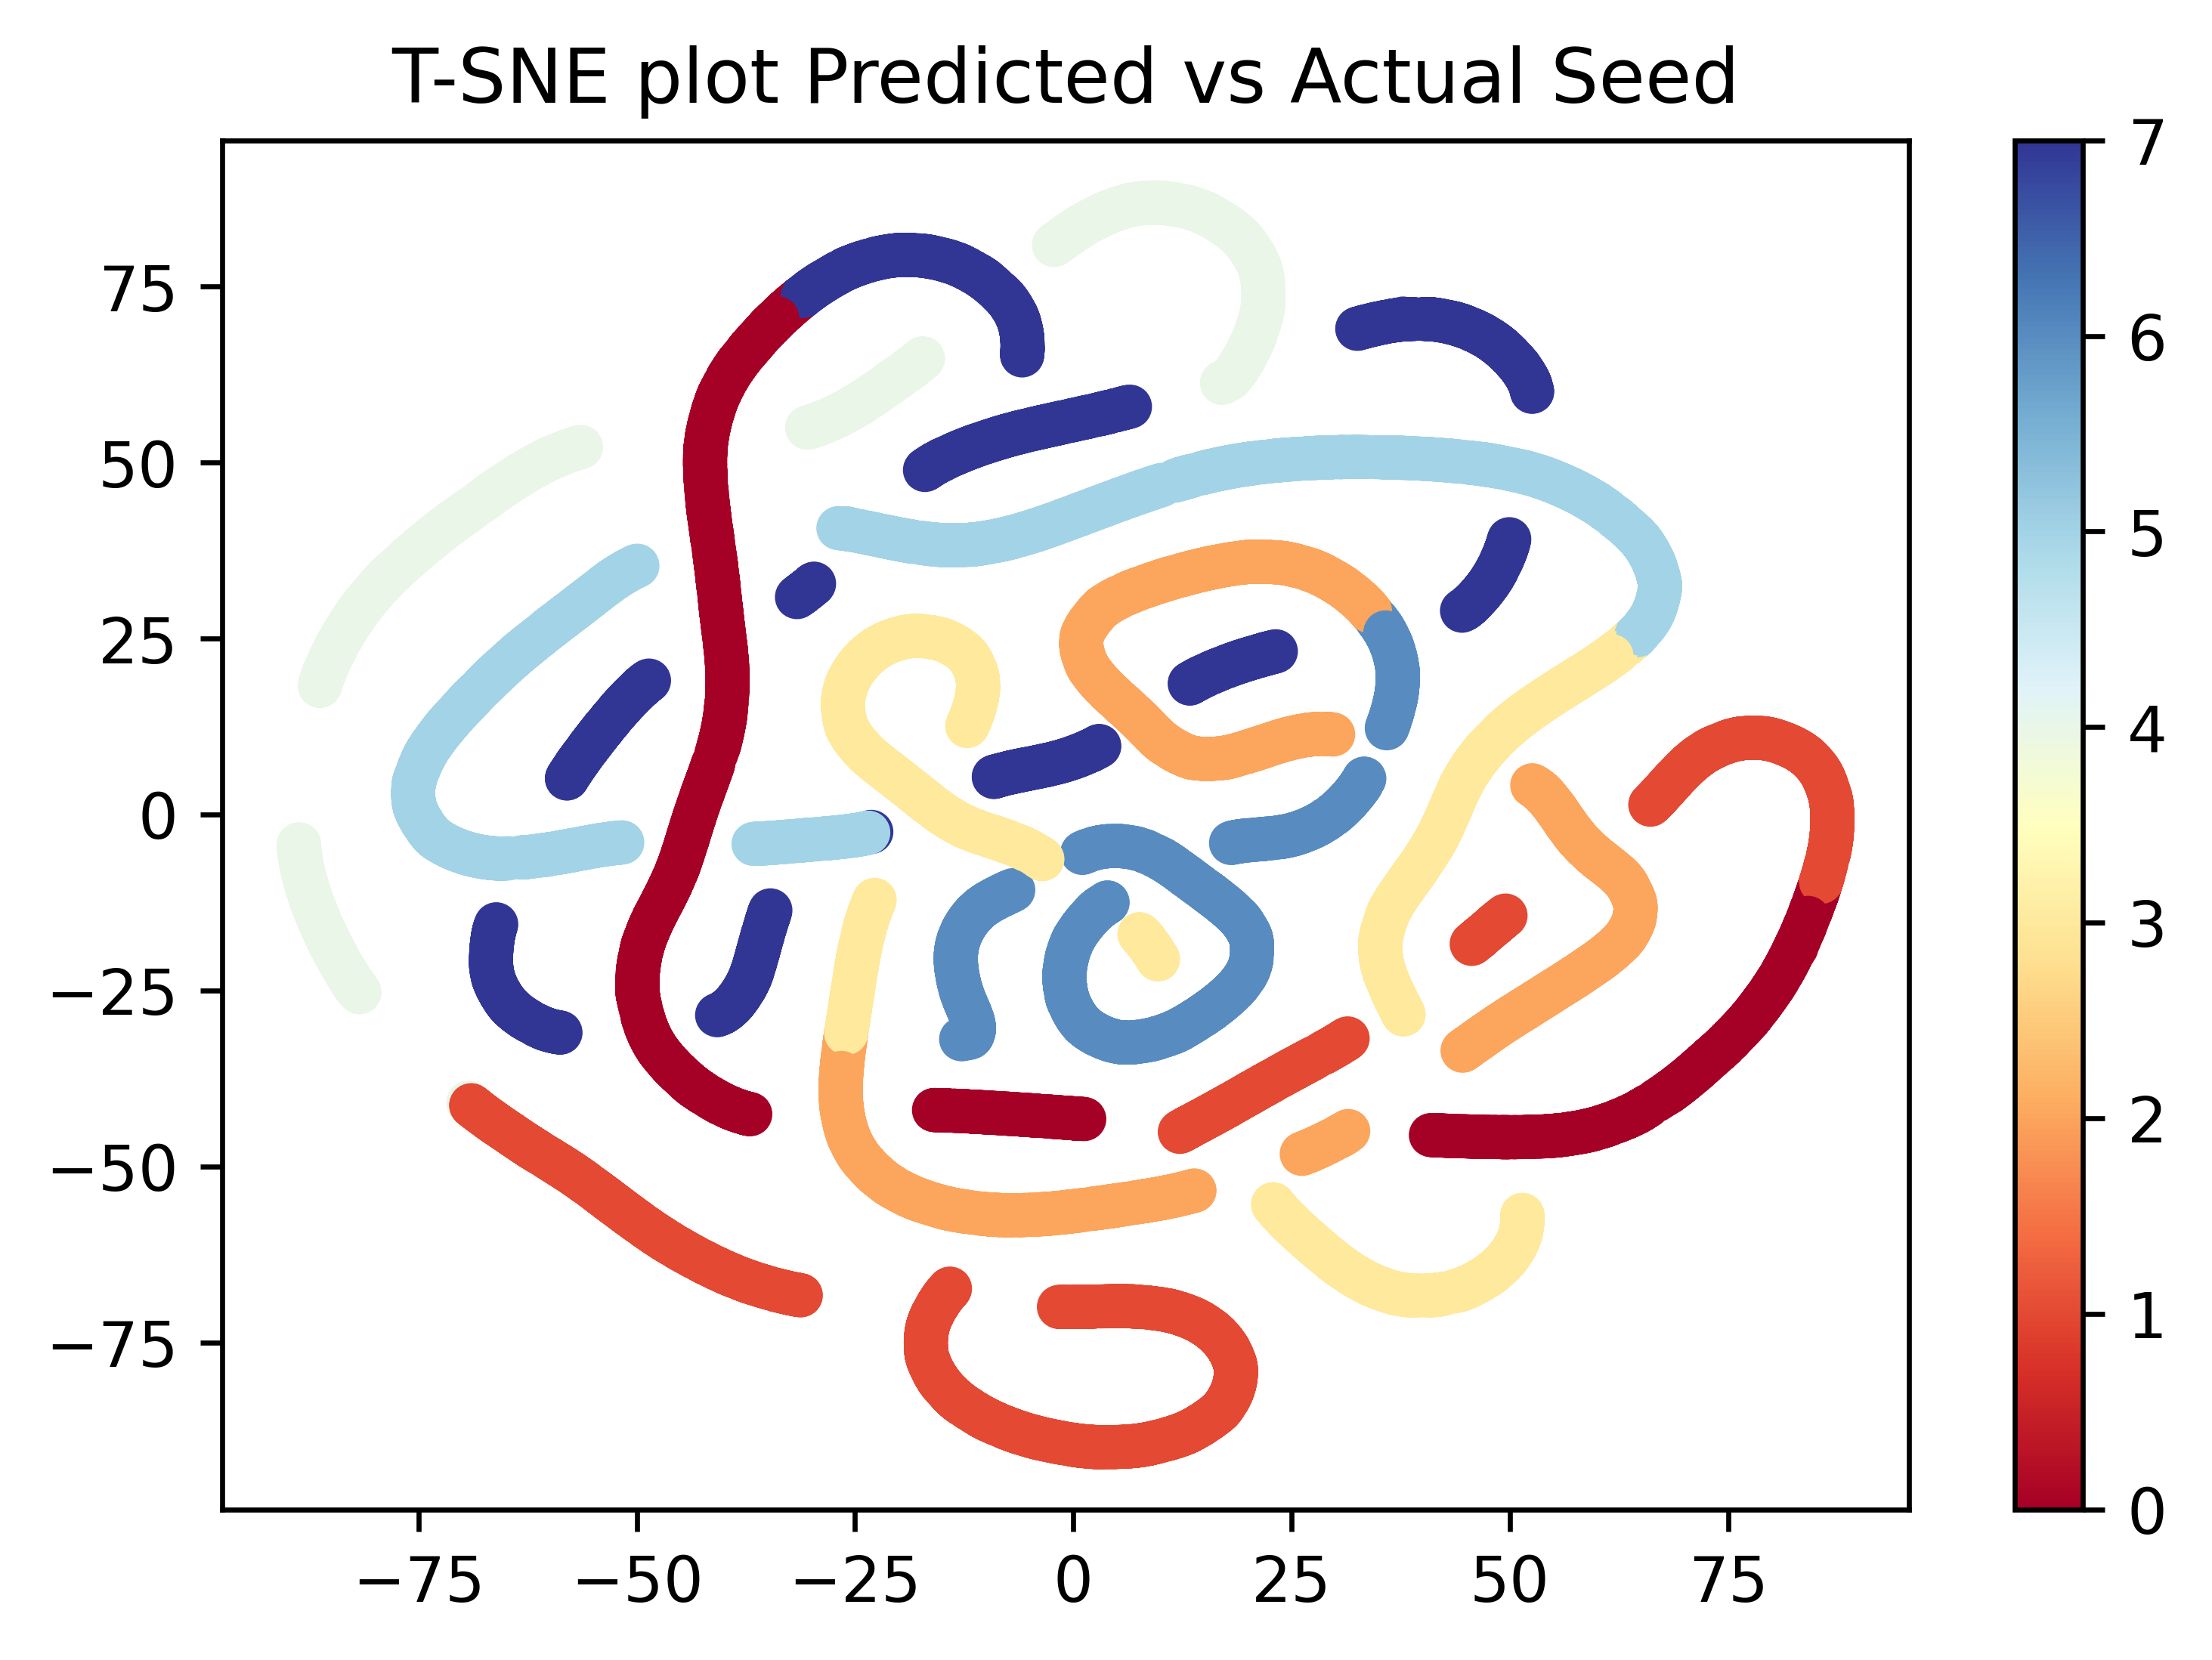

In [40]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components = 2, perplexity = 50, random_state = 1000)
data_tsne = tsne.fit_transform(X)

#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=X.index)
dff = pd.concat([X, df_tsne], axis=1)


# Plot the projected (x,y) coordinates
plt.figure(dpi=600) 
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(x = dff['x'], y = dff['y'], c=dff['predicted_cluster'], cmap=cm)
plt.colorbar(sc)
plt.title('T-SNE plot Predicted vs Actual Seed')
plt.show()